# 비선형 회귀 (IRIS 꽃 품종 판별)

#### 이번에는 비선형 회귀 입니다. 선형 회귀와는 다르게 이제 예측해야하는 y변수가 여러개입니다. 예를 들어, iris 꽃 품종 판별이 있는데 품종은 3개이므로 3개 중에 하나를 예측해야 하는 문제를 들 수 있습니다.

# 드라이브 연동

일단 드라이브 연동해서 파일 가져올 준비 가장 먼저 하시고.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

# 비선형 회귀 서론

#### 비선형 회귀에 대한 이론적인 내용은 구글링을 통해 찾아보시는걸 추천합니다.
#### 코드만 설명을 드릴 예정인데, 비선형 회귀에서 가장 중요한건 활성화함수 입니다. 우리는 활성화 함수를 tensorflow같은 툴을 이용해 함수로 불러오기 이전에, 직접 구현해보겠습니다.
#### 이번에는 함수들을 정의하고 사용해야하는 경우가 있어, class로 직접 모델의 틀을 만들어줄겁니다.

##일단 짧게 그림과함께 설명하자면,

Layer부분은 층 이름과 유형 나타냄, Dense()함수 안에 name=''추가하지 않으면 자동으로 이름 정해짐,
* 입력층 - 첫번째 은닉층 연결해주는 Dense_1
* 첫 은닉층 - 두번째 은닉층 Dense_2
* 두번째 은닉층 - 출력층 Dense_3 

Output shape 부분은 각 층에 몇 개의 출력이 발생했는지 나타냄,
*  (행의 수(샘플), 열의 수(속성)) 의미
* 행의 수는 batch_size 에서 정함, 모델에서 특별히 세지 않아서 None으로 지정
* 8개 입력이 - 첫 은닉층 12개 - 두번째 은닉층 8개 - 출력층 1개가 됨

Param 부분은 파라미터 수 = 총 가중치와 바이어스 수의 합
* Dense_1의 경우, 입력 8개 * 12개 노드 = 96개에서, 각 노드마다의 바이어스 12개, 96+12 = 108이 됨

마지막은 전체 파라미터 합산한 값, Non---은 업데이트 안된 파라미터임
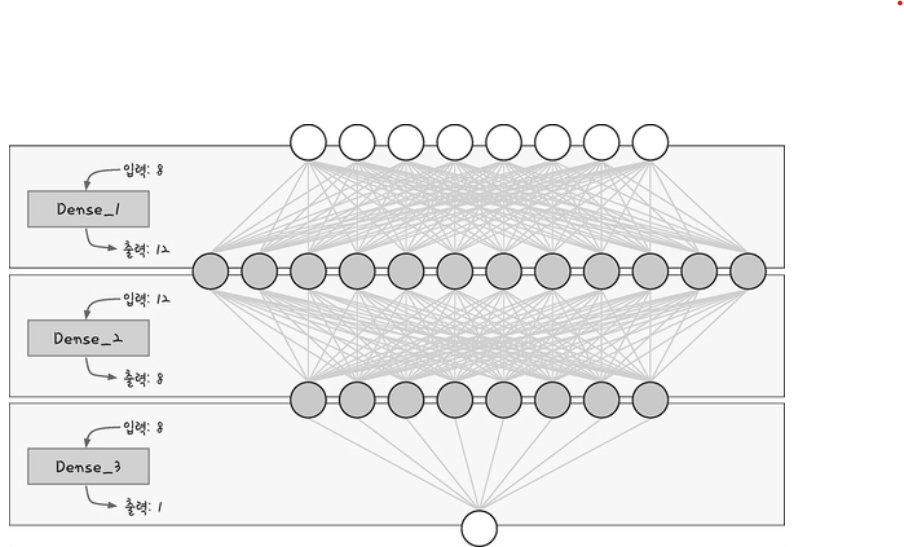

# 비선형 회귀 코드 직접 구현 (Numpy)

In [ ]:
#이번 시간에는 비선형 회귀에서 가장 기본 모델인 XOR 모델을 만들어보겠습니다.

import numpy as np
# 비선형 회귀의 경우 x,y데이터가 2차원 행렬이므로 행렬을 쉽게 처리하는 numpy패키지가 꼭 필요합니다.

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# 시그모이드 함수입니다. 활성화함수 중 하나로, 요약하면 0-1사이의 실수를 출력하기위해 사용.

def numerical_derivative(f, input_data):
    delta_x = 1e-4

    ret = np.zeros_like(input_data)
    it = np.nditer(input_data, flags=['multi_index'])

    while not it.finished:
        idx = it.multi_index

        tmp = input_data[idx]
        input_data[idx] = float(tmp) + delta_x
        fx1 = f(input_data)

        input_data[idx] = float(tmp) - delta_x
        fx2 = f(input_data)

        ret[idx] = (fx1 - fx2) / (2 * delta_x)
        input_data[idx] = tmp
        it.iternext()

    return ret
# 수치 미분 함수입니다. 저번시간에 g_w,g_b를 가지고 w,b를 빼가며 조정해나갔는데, 여기서 g_w,g_b역할을 하는 것이 수치 미분 함수 입니다.
# 이부분은 수학자들이 발견해낸 공식으로 저희가 건들 필요가 없어 따로 설명하지 않겠습니다. 그냥 갖다 쓰시면 됩니다.
# 저희가 구현할 것들은 대부분 변경하고 저희 입맛대로 바꿀 수 있도록 하기 위해서 구현하는 것입니다.


class NonLinearRegression:
# 준비가 끝났으니 이제 직접 모델을 만들어 봅시다. 파이썬에서는 c++에서 사용가능한 class를 이용해 모델틀을 만들 겁니다.
# 비선형 회귀이므로 이름은 NonLinearRegression로 할게요.

    def __init__(self, gate_name, x_data, t_data):
        self.name = gate_name

        # 입력 데이터
        self.__x_data = x_data
        self.__t_data = t_data

        # 임의의 W2, b2, W3, b3 준비
        i =  [[ 2.63259021,  2.44820463 , 4.63134428 , 1.17225176 , 5.48438174,  7.2549209 ],[ 3.28485616 ,-1.69787055,  5.22847983 , 2.02503399 , 5.40761403  ,6.48606646]]
        self.__W2 = np.array(i)
        j = [-4.61606264  ,1.46435451, -7.54664825 ,-2.47371219 ,-2.32749526, -3.09309171]
        self.__b2 = np.array(j)
        k = [[ -6.64307767],[ -4.60866687],[-11.09625077],[ -4.26531046],[  8.01868687],[ 11.17017424]]
        self.__W3 = np.array(k)
        g = [-4.44898273]
        self.__b3 = np.array(g)

        self.__learning_rate = 1e-1
        self.loss_func = self.__feed_forward
    # class를 불러올 때, NonLinearRegression(...) 괄호안에 입력해줘야할 변수들을 정의합니다. __init__으로 정의를 하며, 자세한 내용은 파이썬 class공부를 권장합니다.
    # x_data는 말그대로 입력 데이터, t_data는 출력 데이터인 y를 의미합니다. csv파일에서 x,y 데이터 나눠서 넣어주면 됩니다.
    # 모델을 직접 구현하기 위해 우리는 w,b를 초기화 해줘야합니다. 앞선 선형 회귀에서는 w,b가 하나였지만, 비선형 회귀는 복잡한 구조를 이루고 있습니다. 위 그림처럼요. 
    # 위 그림에서 동그라미 하나가 하나의 노드라고 하는데, 노드 당 w = weight가 하나씩 주어집니다. 즉, weight값이 무수히 많아지게 되겠죠.
    # 또한 Dense는 층을 의미하는데 층마다 b = bias도 하나씩 주어집니다. 마찬가지로 수는 적지만 늘어났죠.
    # 원래는 numpy의 random함수를 이용하여 범위를 정해서 w,b값을 랜덤으로 초기화해주는데, 위에 보이시는 w,b값은 제가 이미 최적의 w,b를 훈련결과로 찾아 넣은것입니다.
    # weight, bias수에 대해서는 수업시간에 말씀드릴게요 조금 복잡해요.
    # 마지막으로, 학습률인 learning_rate를 대략 작게 설정 지수e의 -1승
    # loss_func = 손실함수 = 비용함수 (저번시간에 배운거) 

  
    
    def __feed_forward(self):
    # feed_forward 함수로, 오차를 찾아줍니다. 위에 비용함수랑 같은거
        delta = 1e-7
        #오차를 구하기위해 변수 delta지정 (그냥 필요하다고 이해)

        # 오차를 찾기위해 모든 층을 하나씩 지나가며 계산을 진행합니다. 입력 -> 은닉 ... 은닉 -> 출력

        z2 = np.dot(self.__x_data, self.__W2) + self.__b2        # 입력층 -> 은닉층
        # numpy의 내적 함수 dot -> y = wx + b랑 같은 공식이지만, 2차원 행렬이라 dot함수 사용
        a2 = sigmoid(z2)
        # sigmoid 위에 정의한 함수 이용합니다. 은닉층에 활성화함수로 sigmoid함수가 사용된겁니다. 위 코드의 결과 z2값이 sigmoid안에 들어갑니다.

        z3 = np.dot(a2, self.__W3) + self.__b3
        # 은닉층 -> 출력층
        # 저희가 만들 모델은 층이 2개입니다. (입력층 제외), 그래서 입력 -> 은닉 -> 출력으로 상대적으로 간단한 비성형 회귀 구조입니다.
        y = sigmoid(z3)
        # 출력값이 XOR게이트 이므로 1에 가깝거나 0에 가깝게 출력해야합니다.

        return -np.sum(self.__t_data * np.log(y + delta) + (1 - self.__t_data) * np.log(1 - y + delta))
        # 오차를 측정합니다. 이를 크로스 엔트로피라고 합니다.

    def train(self):
    # 이제 대망의 훈련입니다.
        f = lambda x: self.__feed_forward()
        # 이쪽 식은 잘 이해가 안가지만 저도, 바꿀필요 없으니 그대로 사용하시면 됩니다. 위에 정의했던 feed_forward함수 가져오는것 같습니다.

        print("Initial W2 = ", self.__W2, "b2 = ", self.__b2, "W3 = ", self.__W3, "b3 = ", self.__b3, "error_val = ", self.loss_func())
        # 훈련에 앞서 초기화된 w,b,손실함수=비용함수 를 출력합니다.

        for step in range(8001):
        # 본격적으로 훈련에 들어갑니다. 훈련 횟수는 8001번
            self.__W2 -= self.__learning_rate * numerical_derivative(f, self.__W2)
            self.__b2 -= self.__learning_rate * numerical_derivative(f, self.__b2)
            self.__W3 -= self.__learning_rate * numerical_derivative(f, self.__W3)
            self.__b3 -= self.__learning_rate * numerical_derivative(f, self.__b3)
            # w,b 값을 조정해나가기 위해 , 앞선 수치미분함수 = g_b,g_w같은거 * 학습률 하여 지속적으로 값을 조정해줍니다.

            if step % 400 == 0:
            # 훈련 400번마다 결과 시각화해서 확인합니다.
                print("step = ", step, "W2 = ", self.__W2, "b2 = ", self.__b2, "W3 = ", self.__W3, "b3 = ", self.__b3, "error_val = ", self.loss_func())
                # 몇번째 학습인지, w, b, 오차가 어느정도인지 출력
                k = np.dot(x_data, self.__W2) + self.__b2
                xx = sigmoid(k)
                yy = np.dot(xx, self.__W3) + self.__b3
                

    def predict(self, x_data):
    #예측을 해봅시다. 임의의 값을 넣었을 때, 이 XOR모델이 잘 작동하는지 확인할 수 있습니다.
        z2 = np.dot(x_data, self.__W2) + self.__b2
        a2 = sigmoid(z2)

        z3 = np.dot(a2, self.__W3) + self.__b3
        pro = sigmoid(z3)
        #위와 마찬가지로 2층 구조로 설계해서 예측하면 됩니다.
        if pro < 0.5:
            return 0, pro
        return 1, pro
        #출력되는 결과는 출력값=pro가 0.5를 기준으로 작으면 0을 출력, 크면 1을 출력하는 간단한 구조입니다.

  


# XOR 데이터
x_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).reshape([4, 2])
y_data = np.array([0, 1, 1, 0]).reshape([4, 1])
# XOR모델은 xdata의 두 원소가 다를 때 1을 출력 해줍니다.

# 학습
XOR_Gate = NonLinearRegression("XOR_Gate", x_data, y_data)
XOR_Gate.train()
# 학습을 위해 XOR_Gate라는 이름으로 위에 만든 class함수를 불러옵니다. x,y data는 파일을 불러올 필요 없이 위에 직접 지정할 수 있는 모델이 XOR모델입니다.

# 출력
print(XOR_Gate.predict([0, 0]))
print(XOR_Gate.predict([1, 0]))
print(XOR_Gate.predict([0, 1]))
print(XOR_Gate.predict([1, 1]))
# 훈련한 결과를 predict함수로 테스트 해봅니다. 실제로 잘 훈련되었다면, 0,1,1,0이렇게 y의 출력결과가 나와야겠죠.

# Tensorflow 툴을 이용한 비선형 회귀 구현

#### 직접 비선형 회귀 모델을 만들어 보았습니다. 하지만 이러한 모델은 Weight와 Bias가 무수히 많아 우리가 직접 초기화 해주기 어렵다는 단점이 있습니다. 심지어 층수가 많아지면 그만큼 더 복잡한 모델이 됩니다.
#### 직접 모델을 수정하면서 만들것이 아니라면 우리는 tensorflow에서 툴을 불러와 간편하게 사용할 수 있습니다.

### 텐서플로우 코드 (XOR)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
# 패키지를 사용하기 위해 tensorflow로 부터 Sequential(모델), Dense(층수), optimizers(경사하강법)을 임포트 해줍니다.

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])
# x,y에 대한 XOR 배열을 생성해줍니다.

#1
# model = Sequential()
# model.add(Dense(1, input_dim=2, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
# model.summary()
# =========================이 모델은 층수가 맞지 않아 제대로 학습이 안되는걸 확인할 수 있습니다.
# ========================= model.summary()를 통해 모델 구조를 볼 수 있고, Layer는 층 이름, Output shape는 출력되는 형태 수, parameter수는 x,w,b,y개수입니다. 

#2
# model = Sequential()
# model.add(Dense(4,input_dim=2))
# model.add(Dense(12, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
# model.summary()
#========================이 모델은 정상적으로 학습이 되는걸 확인하실 수 있습니다. 다만 마지막 predict로 테스트 해봤을 때, 값이 극명한 차이를 보여주진 않습니다.

#3
model = Sequential()  # 모델을 생성하겠다는 의미입니다.
model.add(Dense(64, input_dim=2, activation='sigmoid')) # 모델에서 add추가하겠다는 것이며, Dense라는 층을 추가하겠다입니다. input_dim = 입력되는 x의 형태이며 [0,0]처럼 2개임을 알 수 있습니다.
# activation은 활성화함수를 뜻하며, 우리는 sigmoid함수를 사용하겠다고 말합니다.
# 64는 output형태를 말하며, 2개의 input 노드가 들어갔을 때 출력은 64개의 output 노드로 출력하겠다는 의미입니다. 그림 참고***
# 입력층 구간입니다.
# parameter수 192는 입력층에서 2개의 형태에 + bias 1개 더해진 3개에 64개의 노드가 곱해져 총 192개의 파라미터가 만들어집니다.
model.add(Dense(64, activation='sigmoid'))
# 은닉층 구간입니다.
# 입력층에서 64개의 노드가 들어왔고, 다시 64개의 노드로 연결시킵니다. 64+1(bias) * 64 = 4160개의 파라미터가 만들어집니다.
model.add(Dense(1,activation='sigmoid'))
# 출력층 구간입니다.
# 64개의 노드가 들어와서 출력은 1개의 값인 1개의 노드로 빠져나갑니다. 총 64+1(bias) = 65개의 파라미터가 만들어집니다.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
# 모델을 실행시킬때 경사하강법, 손실함수=비용함수, 측정을 어떻게 할건지 정해줍니다.
# 경사하강법은 잘 찾아보시고 현재로선 adam이 가장 성능이 좋습니다.
# 손실함수는 오차 계산하는걸로, binary_crossentropy처럼 2중 분류에 한에 사용하는 손실함수를 사용합니다.
# 측정을 어떻게 할건지는 이중 분류의 정확도로 지정합니다. 학습할때마다 이중 분류의 정확도를 보여줍니다. 1이 100%를 의미하며 1에 가까울수록 학습이 잘된거임.
model.summary()
#모델 종합적인 개요를 보여줌
# #========================기본적으로 비선형 회귀에서 가장 많이 사용하는 모델 구조입니다. 테스트 해보면 0인 값은 매우 작고, 1인 값은 매우 1에 유사함을 확인할 수 있습니다.

model.fit(X, y, epochs=1000)
# #========================epoch수를 마음대로 조정해 원하는 학습 결과를 얻을 수 있습니다.

print(model.predict(X))
# #========================이걸로 모델 테스트 가능, 지금은 기존에 넣었던 X를 학습된 모델에 다시 넣고 값을 얻어봄.


# # #3을 보듯이 모델이 복잡해지면 우리가 생각해야하는 파라미터 수는 기하급수적으로 늘어납니다. 물론 #3처럼 극단적으로 모델을 복잡하게 할필요는 없지만, Iris같은 꽃 품종 판별하는
# # 모델의 경우에는 이러한 모델구조를 사용해야해서 직접 구현하기보다는 툴을 사용하는것이 바람직합니다.

### 텐서플로우 코드 (IRIS 더 복잡한 모델 구조)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
#마찬가지로 tensorflow 패키지 불러옴

import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

# 아이리스 데이터를 불러옵니다.
data = pd.read_csv('/content/gdrive/MyDrive/ROBOTICS/신호등/train')

# 속성을 X, 클래스를 y로 저장합니다.
# iloc[행 인덱스, 열 인덱스]
X=np.array(data[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']])
y=np.array(data['Species'])


from sklearn.model_selection import train_test_split

# 학습셋과 테스트셋을 구분합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)


# 원-핫 인코딩 처리를 합니다.
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
# y출력 데이터의 경우 영어로된 꽃 이름이기때문에 원핫 인코딩이라는 숫자로 데이터를 바꾸는 전처리 과정이 필요합니다.
# 품종이 예를 들어 ABC 인 경우 A = [1,0,0], B=[0,1,0], C=[0,0,1] 이렇게 말입니다.

# 모델 설정
model = Sequential()
model.add(Flatten())
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()
#보면은, input_dim=4인데, Iris의 경우 x특성이 4개 이므로 4라고 지정해줘야합니다.
#활성화함수로는 relu함수를 사용했는데, 자세한 것은 검색해보시고 요약하자면 0보다 값이 크면 값을 그대로 출력, 0보다 값이 작으면 0을 출력하는 함수입니다.
#출력할때는 softmax라는 함수를 사용했는데, 이는 자세한것은 검색, 요약하면 확률을 나타내주는 함수로 3이라고 지정하면, 3가지에 대한 확률을 나누어 가장 큰 확률을 출력해줍니다.

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 실행
history = model.fit(X_train, y_train, epochs=100, batch_size=6)
# 훈련할 데이터가 너무 많은경우 우리는 batch_size를 이용해 훈련 데이터를 분리해서 묶어서 조금씩 학습시킬 수있습니다. 자세한건 검색

# 테스트셋에 적용해 정확도 구함
score = model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])
# 테스트 데이터를 나눠서 가지고 있으므로, 이제 테스트를 할 데이터를 가지고 evaluate함수를 통해 테스트 해볼수 있습니다.

# 결과를 보시면 XOR같은 단순하게 정답이 확실한 모델과 달리 꽃의 특성상 변종도 있을 수 있고 이러한 요인 때문에 정확도는 100%에 수렴하기란, 현실적으로 어렵습니다.
# 그래도 정확도가 95%이상이라는 것은 실제 사용할 수 있는 모델이라는 말이니 이 점 참고해주세요.

### 그 외 텐서플로우 모델 (최종성적 구하는 모델)

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# 중간 고사, 기말 고사, 가산점 점수 3개를 고려하여 최종 점수를 뽑는 모델인데, 일단 규칙을 모르겠어서 어떤 규칙이 있는데 그걸 기계가 학습한다고 보면됨
# 인간이 계산하기 어려운 규칙도 기계가 알아서 알아내줌
X = np.array([[70,85,11], [71,89,18], [50,80,20], [99,20,10], [50,10,10]]) 
y = np.array([73, 82 ,72, 57, 34]) # 최종 성적

model = Sequential()
model.add(Dense(1, input_dim=3, activation='linear'))
# linear활성화 함수는 그냥 직선 함수라고 보면됩니다.

sgd = optimizers.SGD(lr=0.0001)
model.compile(optimizer=sgd, loss='mse', metrics=['mse'])
# 비용함수로 mse를 사용했는데 검색해보세요, 일단 adam보단 안좋음
model.fit(X, y, epochs=2000)

print(model.predict(X))

X_test = np.array([[20,99,10], [40,50,20]])
print(model.predict(X_test))

# 모델 저장 & 불러오기

In [ ]:
# 모델 이름과 저장할 위치를 함께 지정합니다.
model.save('./data/model/my_model.hdf5')

# 모델 불러오기
from tensorflow.keras.models import Sequential, load_model
model = load_model('./data/model/my_model.hdf5')

# weight, bias나 layer(층)에서의 파라미터 값 확인

Tensorflow 함수 이용

In [ ]:
import numpy as np

# 과학적 표기법 대신 소수점 6자리까지 나타낸다.
np.set_printoptions(precision=18, suppress=True)

hidden_2 = model.layers[0]
hidden_2.name
weights, biases = hidden_2.get_weights()
print(weights.shape)
print(biases.shape)
print(weights)
print(biases)

hidden_2 = model.layers[1]
hidden_2.name
weights, biases = hidden_2.get_weights()
print(weights.shape)
print(biases.shape)
print(weights)
print(biases)

hidden_2 = model.layers[2]
hidden_2.name
weights, biases = hidden_2.get_weights()
print(weights.shape)
print(biases.shape)
print(weights)
print(biases)

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

# 과학적 표기법 대신 소수점 6자리까지 나타낸다.
np.set_printoptions(precision=12, suppress=True)
# 5. 은닉층의 출력 확인하기
intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
intermediate_output = intermediate_layer_model(x)
intermediate_layer_model2 = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)
intermediate_output2 = intermediate_layer_model2(x)
intermediate_layer_model3 = tf.keras.Model(inputs=model.input, outputs=model.layers[2].output)
intermediate_output3 = intermediate_layer_model3(x)

print('======== Inputs ========')
print(x)

print('\n======== Outputs of Hidden Layer ========')
print(intermediate_output)
print('\n======== Outputs of Hidden Layer ========')
print(intermediate_output2)
print('\n======== Outputs of Hidden Layer ========')
print(intermediate_output3)
# print('\n======== Outputs of Output Layer ========')
# pred = model.predict(x)
# print(pred)

# print(y)